In [1]:
import bempp.api
import numpy as np
import dolfin

In [2]:
from dolfin import *     
from dolfin_utils.meshconvert import meshconvert

theta = 10.0
pow_bnd = 1.0

FEM_u_error = []
FEM_bnd_conv = []

mesh_size = []
iter_num = []

trace_variable = True
dir_imp = False

########################################################################
grid_size = [6, 5, 4, 3, 2, 1]
 
tol=1e-8

In [3]:
from dolfin import *     
from dolfin_utils.meshconvert import meshconvert
import pylab as plt
from bempp.api import fenics_interface
from bempp.api.fenics_interface import FenicsOperator
from scipy.sparse.linalg.interface import LinearOperator
from scipy.sparse.linalg import gmres

parameters["allow_extrapolation"] = True 

for m in grid_size:
    ######################### Mesh and spaces ##################################
    mesh_file = "Sphere_h_0_"+format(m)+".msh"
    meshconvert.convert2xml(mesh_file, "mesh.xml", iformat=None)
    mesh = dolfin.Mesh("mesh.xml")
    
    fenics_space = dolfin.FunctionSpace(mesh, "Lagrange", 1)
    bnd = dolfin.BoundaryMesh(mesh, 'exterior')
    trace_space, trace_matrix  = fenics_interface.coupling.fenics_to_bempp_trace_data(fenics_space)
    
    trace_op = LinearOperator(trace_matrix.shape, lambda x:trace_matrix*x)
    trace_T_op = LinearOperator(trace_matrix.T.shape, lambda x:trace_matrix.T*x)
    
    ######################### FEM variables ##################################
    u = dolfin.TrialFunction(fenics_space)
    v = dolfin.TestFunction(fenics_space)

    nor = dolfin.FacetNormal(mesh)
    h = dolfin.CellDiameter(bnd)

    h1 = []
    for cell in cells(bnd):
        h1.append(cell.inradius())

    hmax = max(h1)

    print(hmax)
    mesh_size.append(hmax)

# #     ################################### Example 1 #############################################
# #     hybrid         -->  SLOW
# #     hybrid + weak  -->  FINE
# #     Nitsche        -->  FINE
# #     Nitsche + weak -->  FINE
#     u_D = dolfin.Function(fenics_space)
#     u_Dir = dolfin.Expression('sin(pi*x[0]) * sin(pi*x[1]) * sinh(sqrt(2)*pi*x[2])', degree=2) 
#     u_D.interpolate(u_Dir)
    
#     rhs_f = dolfin.Constant(0)

#     ################################## Example 2 #############################################
# #     hybrid         -->  SLOWER
# #     hybrid + weak  -->  FINE
# #     Nitsche        -->  FINE
# #     Nitsche + weak -->  FINE
#     u_D = dolfin.Function(fenics_space)
#     u_Dir = dolfin.Expression('1/(4*pi*sqrt((x[0]-3)*(x[0]-3)+x[1]*x[1]+x[2]*x[2]))', degree=2) 
#     u_D.interpolate(u_Dir)

#     rhs_f = dolfin.Constant(0)

    ################################### Example 3 #############################################
#     hybrid         -->  SLOWER
#     hybrid + weak  -->  FINE
#     Nitsche        -->  FINE
#     Nitsche + weak -->  FINE
    u_D = dolfin.Function(fenics_space)
    u_Dir = dolfin.Expression('-(x[0]*x[0]+x[1]*x[1]+x[2]*x[2] - 3)/(8*pi)', degree=2) 
    u_D.interpolate(u_Dir)
    
    rhs_f = Constant(3./(4.*pi))

#     ################################### Example 4 #############################################
# #     hybrid         -->  WEIRD
# #     hybrid + weak  -->  FINE
# #     Nitsche        -->  FINE
# #     Nitsche + weak -->  FINE
#     u_D = dolfin.Function(fenics_space)
#     u_Dir = dolfin.Expression('sin(pi*(x[0]*x[0]+x[1]*x[1]+x[2]*x[2]))/(2*pi) + cos(pi*(x[0]*x[0]+x[1]*x[1]+x[2]*x[2]))/(2*pi) + (2*pi+1)/(2*pi)', degree=2) 
#     u_D.interpolate(u_Dir)
    
#     rhs_f = dolfin.Expression('sin(pi*(x[0]*x[0]+x[1]*x[1]+x[2]*x[2]))*(2*pi*(x[0]*x[0]+x[1]*x[1]+x[2]*x[2])+3) + cos(pi*(x[0]*x[0]+x[1]*x[1]+x[2]*x[2]))*(2*pi*(x[0]*x[0]+x[1]*x[1]+x[2]*x[2])-3)', degree=2) 
    
    
    
    beta = theta/hmax
    
    ######################### RHS ##################################
    FEM_rhs = v*rhs_f*dolfin.dx() + v*u_D*dolfin.dx() 
    BEM_rhs = dolfin.dot(dolfin.grad(u_D),nor)*v*dolfin.ds()
    
    # The rhs from the FEM
    rhs_fem = dolfin.assemble(FEM_rhs)
    # rhs_fem = np.zeros(mesh.num_vertices())

    # The rhs from the BEM
    rhs_bem = trace_op*dolfin.assemble(BEM_rhs) #np.zeros(trace_space.global_dof_count) #trace_op*dolfin.assemble(BEM_rhs) 
    if dir_imp:
        rhs_bem = trace_op*dolfin.assemble(BEM_rhs + beta**pow_bnd*v*u_D*dolfin.ds()) 
    
    
    # The combined rhs
    rhs = np.concatenate([rhs_fem, rhs_bem])
    
    ######################### LHS ##################################
    
    A_mat = (dolfin.dot(dolfin.grad(u),dolfin.grad(v))) * dolfin.dx() \
                        + u*v*dolfin.dx() \
                        - dolfin.dot(dolfin.grad(v),nor)*u*dolfin.ds() \
                        - dolfin.dot(dolfin.grad(u),nor)*v*dolfin.ds() \
                        + beta*v*u*dolfin.ds() #+ beta**2*v*u*dolfin.ds()
    
    
    A = FenicsOperator(A_mat)
    B =  FenicsOperator(dolfin.dot(dolfin.grad(u),nor)*v*dolfin.ds() - beta*v*u*dolfin.ds())  
    BT = FenicsOperator(dolfin.dot(dolfin.grad(v),nor)*u*dolfin.ds() - beta*v*u*dolfin.ds()) 
    C =  FenicsOperator(beta*v*u*dolfin.ds() )  # + beta**4*v*u*dolfin.ds)

    # The rhs from the BEM
    if trace_variable:
        blocks = [[None,None],[None,None]]

        blocks[0][0] =  A.weak_form()
        blocks[0][1] =  BT.weak_form()*trace_T_op
        blocks[1][0] =  trace_op*B.weak_form()
        blocks[1][1] =  trace_op*C.weak_form()*trace_T_op

        if dir_imp:
            blocks[1][1] += trace_op*beta**(pow_bnd-1)*C.weak_form()*trace_T_op
                  
        blocked = bempp.api.BlockedDiscreteOperator(np.array(blocks))

        ######################### Solver ##################################
        # Create a callback function to count the number of iterations
        it_count = 0
        def count_iterations(x):
            global it_count
            it_count += 1

        soln, info = gmres(blocked, rhs, M = None, tol = tol, callback=count_iterations)

        soln_fem = soln[:fenics_space.dim()]
                  
        iter_num.append(it_count)
        print("Number of iterations: {0}".format(it_count))

        ######################### Error ##################################
        # Store the real part of the FEM solution
        u = dolfin.Function(fenics_space)
        u.vector()[:] = np.ascontiguousarray(np.real(soln_fem))
                  
    else:
        FEM_rhs = FEM_rhs - dolfin.dot(dolfin.grad(v),nor)*u_D*dolfin.ds() \
                    + beta*v*u_D*dolfin.ds()
#                     + dolfin.dot(dolfin.grad(u_D),nor)*v*dolfin.ds() \
        
        u =  dolfin.Function(fenics_space)
        dolfin.solve(A_mat == FEM_rhs, u)
    
    error = (u_D-u)**2*dolfin.dx()
    L2_error = dolfin.assemble(error)
    
    FEM_u_error.append(np.sqrt(L2_error))
    
    error_bnd = (u_D-u)**2*dolfin.ds()
    L2_error_bnd = dolfin.assemble(error_bnd)
    FEM_bnd_conv.append(L2_error_bnd)

Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 55 vertices
Found all vertices
Expecting 104 cells
Found all cells
Conversion done
0.153674224813
Number of iterations: 181
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 165 vertices
Found all vertices
Expecting 502 cells
Found all cells
Conversion done
0.121163559312
Number of iterations: 569
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 242 vertices
Found all vertices
Expecting 763 cells
Found all cells
Conversion done
0.100951859867
Number of iterations: 591
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 361 vertices
Found all vertices
Expecting 1260 cells
Found all cells
Conversion done
0.084145656595
Number of iterations: 726
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 735 vertices
Found all vertices
Expecting 2979 cells
Found all cells
Conversion done
0.0678738889126
Number of iterations: 1046
Convert

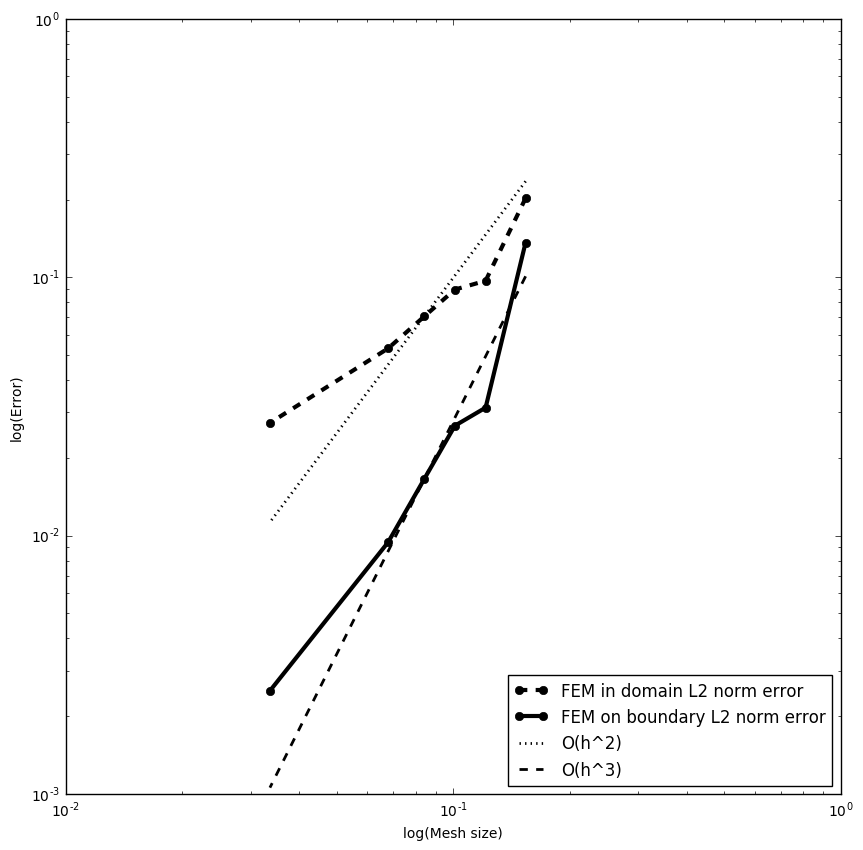

In [4]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)
inv_mesh_size =  np.true_divide(1, mesh_size)

mult = abs(FEM_u_error[len(mesh_size)//2]/mesh_size[len(mesh_size)//2])
o_mesh_size = np.multiply(mult, mesh_size)

mesh_pow_2 = np.multiply(mesh_size, mesh_size)
mult = abs(FEM_u_error[len(mesh_size)//2]/mesh_pow_2[len(mesh_size)//2])
o_mesh_pow_2 = np.multiply(mult, mesh_pow_2)

mesh_pow_3 = np.multiply(mesh_pow_2, mesh_size)
mult = abs(FEM_bnd_conv[len(mesh_size)//2]/mesh_pow_3[len(mesh_size)//2])
o_mesh_pow_3 = np.multiply(mult, mesh_pow_3)

plt.figure( figsize=(10, 10), dpi=100)
plt.loglog(mesh_size[0:len(FEM_u_error)], FEM_u_error, 'ko--', linewidth=3, label='FEM in domain L2 norm error')
plt.loglog(mesh_size[0:len(FEM_bnd_conv)], FEM_bnd_conv, 'ko-', linewidth=3, label='FEM on boundary L2 norm error')
# plt.loglog(mesh_size, o_mesh_size, 'k:', linewidth=2, label='O(h)')
plt.loglog(mesh_size, o_mesh_pow_2, 'k:', linewidth=2, label='O(h^2)')
plt.loglog(mesh_size, o_mesh_pow_3, 'k--', linewidth=2, label='O(h^3)')
# plt.loglog(mesh_size, error_between, 'ko-', linewidth=3, label='L2 norm error in between')
# plt.loglog(mesh_size, BEM_u_error, 'ks-', linewidth=3, label='BEM L2 norm error')
# plt.loglog(mesh_size, BEM_lambda_error, 'ks:', linewidth=3, label='BEM H1 semi-norm error')
plt.legend(loc='lower right')
#plt.title('Sphere - beta = 0, p = 1')
plt.xlabel('log(Mesh size)')
plt.ylabel('log(Error)')
plt.show()

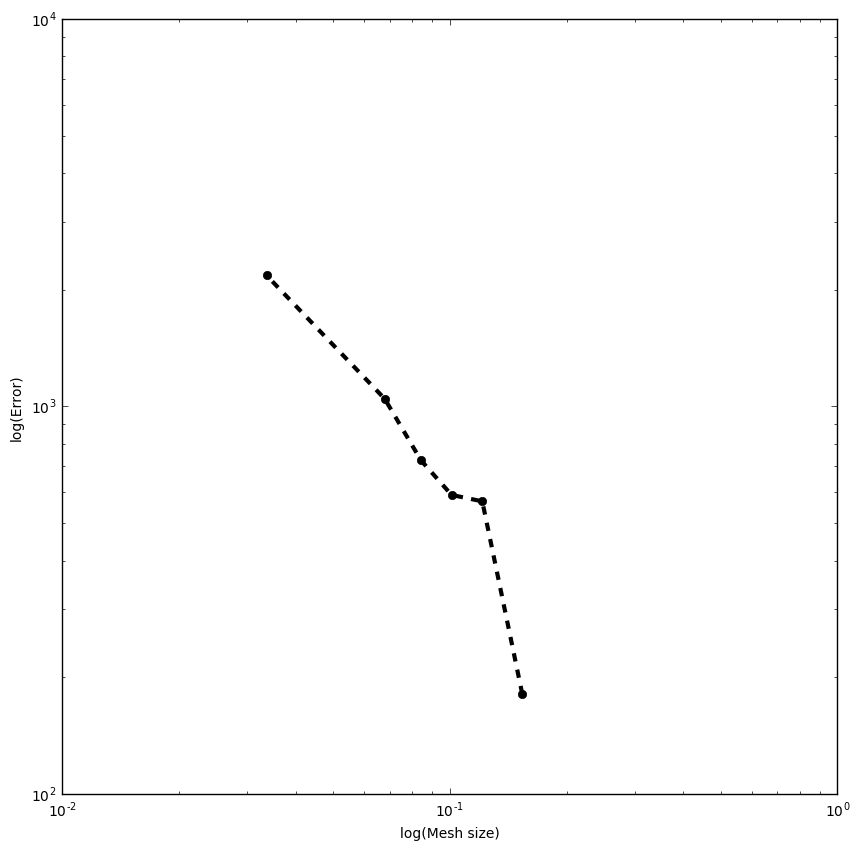

In [5]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

plt.figure( figsize=(10, 10), dpi=100)
plt.loglog(mesh_size[0:len(iter_num)], iter_num, 'ko--', linewidth=3)
# plt.legend(loc='lower right')
#plt.title('Sphere - beta = 0, p = 1')
plt.xlabel('log(Mesh size)')
plt.ylabel('log(Error)')
plt.show()